In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
for image_batch, label_batch in dataset.take(1): #it gives you one batch
    print(image_batch.shape)
    print(label_batch.numpy())
    

(32, 256, 256, 3)
[1 1 1 0 0 1 0 1 0 1 0 1 2 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 2 1 2 1]


In [13]:
# 3 is for RGB Channels

In [14]:
for image_batch, label_batch in dataset.take(1): #it gives you one batch
    print(image_batch[0].shape)
    

(256, 256, 3)


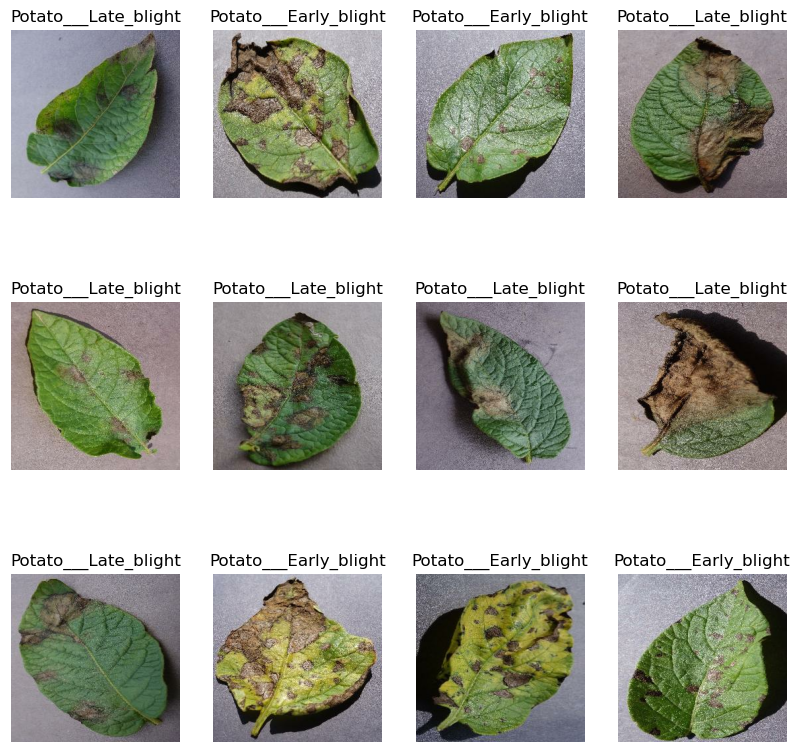

In [15]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): #it gives you one batch
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #it is float so astype("uint8") is used
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [16]:
len(dataset)

68

80% ==> training

10% ==> validation

10% ==> test

In [17]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds = dataset.take(54)

In [19]:
test_ds = dataset.skip(54)

In [20]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [21]:
val_ds = test_ds.take(6)

In [22]:
test_ds = test_ds.skip(6)

In [23]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

54

In [26]:
len(test_ds)

8

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [28]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [29]:
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
     resize_and_rescale,
     data_augmentation,
     keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64, (3,3), activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64, (3,3), activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64, (3,3), activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64, (3,3), activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64, (3,3), activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Flatten(),
     keras.layers.Dense(64, activation = 'relu'),
     keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [32]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 223s 4s/step - loss: 0.9148 - accuracy: 0.5145 - val_loss: 0.8591 - val_accuracy: 0.7500
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.6861 - accuracy: 0.7153 - val_loss: 0.6115 - val_accuracy: 0.8073
Epoch 3/50
54/54 [==============================] - 88s 2s/step - loss: 0.4143 - accuracy: 0.8223 - val_loss: 0.4702 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 90s 2s/step - loss: 0.3108 - accuracy: 0.8808 - val_loss: 0.3238 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 91s 2s/step - loss: 0.3185 - accuracy: 0.8646 - val_loss: 0.3266 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.2158 - accuracy: 0.9149 - val_loss: 0.4256 - val_accuracy: 0.8125
Epoch 7/50
54/54 [==============================] - 93s 2s/step - loss: 0.2180 - accuracy: 0.9167 - val_loss: 0.2833 - val_accuracy: 0.8958
Epoch 8/50
54/54 [=

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 476ms/step - loss: 0.3383 - accuracy: 0.8906


In [35]:
scores

[0.3382720351219177, 0.890625]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
history.history['accuracy']

[0.5144675970077515,
 0.7152777910232544,
 0.8223379850387573,
 0.8807870149612427,
 0.8645833134651184,
 0.9149305820465088,
 0.9166666865348816,
 0.9137731194496155,
 0.9328703880310059,
 0.9398148059844971,
 0.9456018805503845,
 0.9519675970077515,
 0.9473379850387573,
 0.9537037014961243,
 0.9496527910232544,
 0.9618055820465088,
 0.9560185074806213,
 0.9565972089767456,
 0.9716435074806213,
 0.9681712985038757,
 0.9612268805503845,
 0.9797453880310059,
 0.9693287014961243,
 0.9728009104728699,
 0.96875,
 0.9803240895271301,
 0.9716435074806213,
 0.9780092835426331,
 0.9826388955116272,
 0.9791666865348816,
 0.9762731194496155,
 0.9809027910232544,
 0.9855324029922485,
 0.9629629850387573,
 0.9681712985038757,
 0.9809027910232544,
 0.9861111044883728,
 0.9866898059844971,
 0.9861111044883728,
 0.9635416865348816,
 0.9768518805503845,
 0.9890046119689941,
 0.9791666865348816,
 0.9901620149612427,
 0.9895833134651184,
 0.9895833134651184,
 0.9884259104728699,
 0.9814814925193787,
 0.

In [40]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

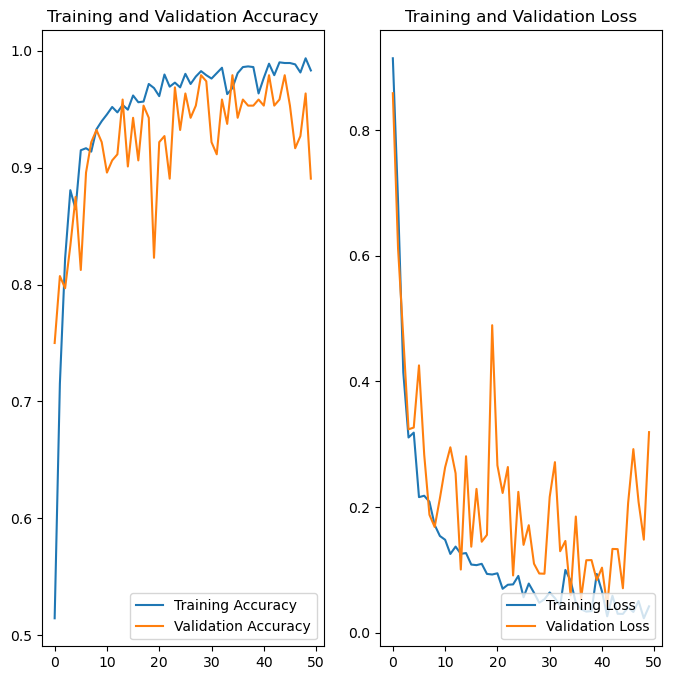

In [41]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss , label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 810ms/step
predicted label: Potato___healthy


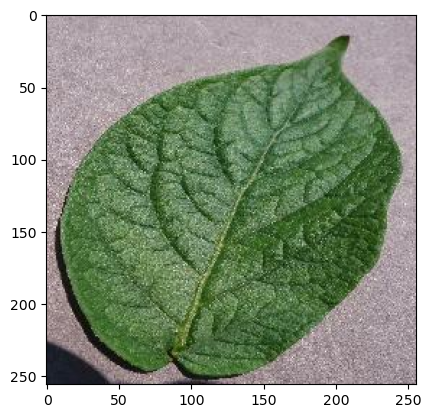

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 49ms/step


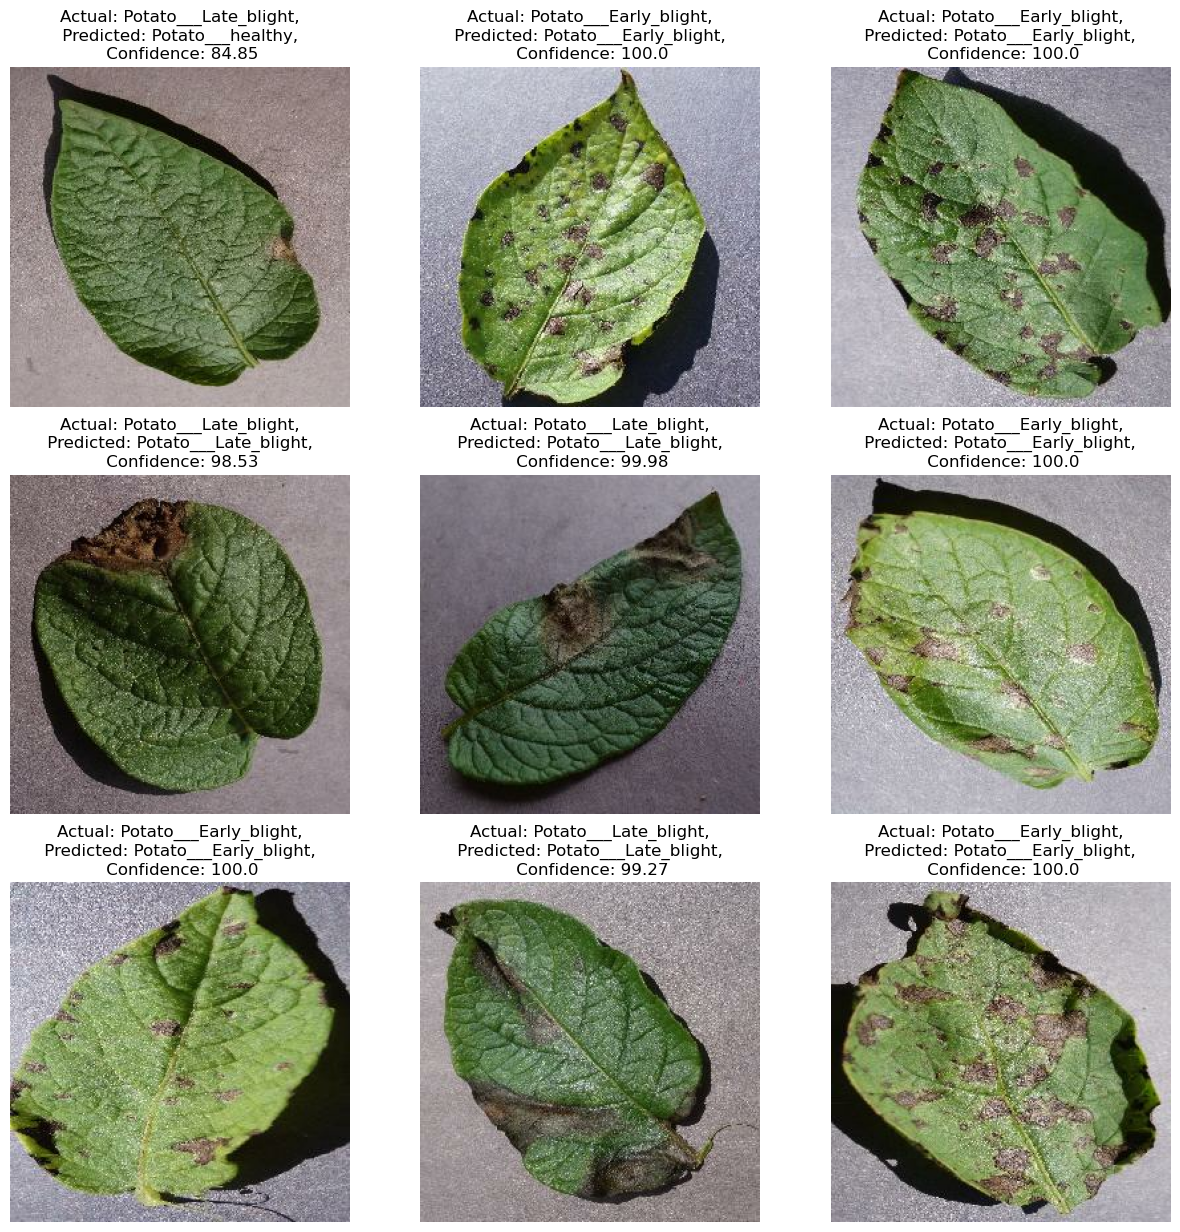

In [44]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}")
        
        
        plt.axis("off")
    

In [46]:
import pickle
pickle.dump(model, open('potato_disease.pkl','wb'))


In [49]:
model_version=1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
